In [16]:
%load_ext autoreload
%autoreload 2

In [12]:
import importlib
from model.fasterrcnn import *
from model.advattack import *
from data_utils.utils import *
from data_utils.arraytools import *

import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Model

In [2]:
model = load_Faster_RCNN(backbone='resnet18')

model.to(device)

checkpoint = torch.load('./saved_models/fasterrcnn_resnet18_2021-03-27_fresh.pth')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

## Testing

In [3]:
test_img_list, test_bboxes = wider_read(limit_images=None, train=False)

test_dataset = WiderDataset(test_img_list, test_bboxes)

test_loader = DataLoader(test_dataset,
                         batch_size=1,
                         shuffle=True,
                         num_workers=0,
                         collate_fn=collate_fn
                         )

In [4]:
start = time.time()

prediction_info = []
target_info = []
model.eval()

for images, targets in test_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():
        predictions = model(images)
    
    predictions = [{k: v.to('cpu').detach() for k, v in t.items()} for t in predictions]
    targets = [{k: v.to('cpu').detach() for k, v in t.items()} for t in targets]
    prediction_info.append(predictions)
    target_info.append(targets)
    images = list(image.detach() for image in images)
    images.clear()
#     targets.clear()
    torch.cuda.empty_cache()

end = time.time()
print(f"Time elapsed in Predicting: {(end - start)/60:.2f} minutes")
prediction_info = list(itertools.chain(*prediction_info))
target_info = list(itertools.chain(*target_info))

Time elapsed in Predicting: 15.96 minutes


In [5]:
# model.to('cpu')
# torch.cuda.empty_cache()

In [15]:
importlib.reload(data_utils.arraytools)

NameError: name 'data_utils' is not defined

In [7]:
results = {}
for i in range(4,11):
    r_temp = evaluation(prediction_info, target_info, iou_thresh=i/10, interpolation_method='EveryPoint')
    results[i/10] = r_temp
    

Processing : 100%|██████████| 3135/3135 [00:14<00:00, 218.41it/s]


In [23]:
for thres, result in results.items():
    prec = result['total TP']/(result['total TP'] + result['total FP'])
    rec = result['total TP']/result['total positives']
    print(f"For the Threshold {thres}: \nAverage Precision: {result['AP']:.2f} Total Recall: {rec:.2f}")
#     PlotPrecisionRecallCurve(result)
    print()

For the Threshold 0.4: 
Average Precision: 0.61 Total Recall: 0.68

For the Threshold 0.5: 
Average Precision: 0.59 Total Recall: 0.65

For the Threshold 0.6: 
Average Precision: 0.54 Total Recall: 0.61

For the Threshold 0.7: 
Average Precision: 0.44 Total Recall: 0.51

For the Threshold 0.8: 
Average Precision: 0.26 Total Recall: 0.35

For the Threshold 0.9: 
Average Precision: 0.04 Total Recall: 0.13

For the Threshold 1.0: 
Average Precision: 0.00 Total Recall: 0.01



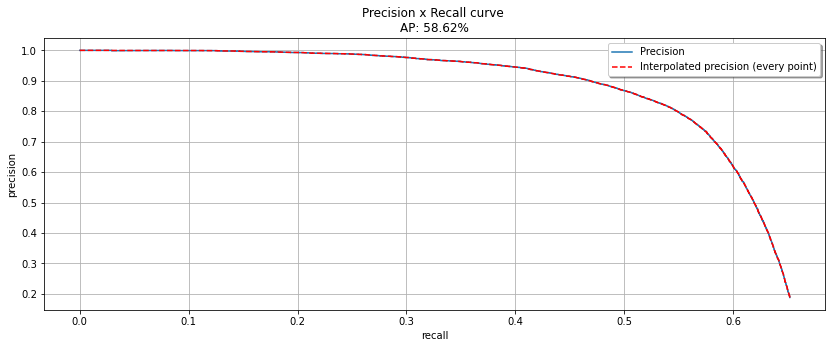

In [30]:
PlotPrecisionRecallCurve(results[0.5])

In [26]:
r = evaluation(prediction_info, target_info, iou_thresh=0.5, interpolation_method='EveryPoint')

Processing : 100%|██████████| 3135/3135 [00:14<00:00, 216.19it/s]


## Adversarial Attack

In [53]:
detector = PyTorchFasterRCNN(model=model, clip_values=(0, 1), preprocessing=None)
attack = ProjectedGradientDescent(detector, eps=0.05, eps_step=0.01, max_iter=50, verbose=False)

In [54]:
attack_img_list, attack_bboxes = wider_read(limit_images=500, train=False)

attack_dataset = WiderDataset(attack_img_list, attack_bboxes)

attack_loader = DataLoader(attack_dataset,
                         batch_size=1,
                         shuffle=True,
                         num_workers=0,
                         collate_fn=collate_fn
                         )

In [55]:
start = time.time()

adv_image_list = []
prediction_info = []
attack_info = []
target_info = []

for images, targets in attack_loader:
    
    org_images = list(image.clone().to(device) for image in images)
    attack_images = np.array([tonumpy(image.clone()) for image in images])
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    adv_image = attack.generate(x=attack_images, y=None)
    adv_image_list.append(adv_image[0].copy())
    adv_image = [totensor(adv_image[0].copy()).to(device)]
#     print('Image Generated')
    
    model.eval()
    
    with torch.no_grad():
        org_predictions = model(org_images)
        adv_predictions = model(adv_image)

    
    org_predictions = [{k: v.to('cpu').detach() for k, v in t.items()} for t in org_predictions]
    adv_predictions = [{k: v.to('cpu').detach() for k, v in t.items()} for t in adv_predictions]
    targets = [{k: v.to('cpu').detach() for k, v in t.items()} for t in targets]
    
    prediction_info.append(org_predictions)
    attack_info.append(adv_predictions)
    target_info.append(targets)
    
    org_images = list(image.detach() for image in org_images)
    adv_image = list(image.detach() for image in adv_image)
    org_images.clear()
    adv_image.clear()
    torch.cuda.empty_cache()

end = time.time()
print(f"Time elapsed in Predicting: {(end - start)/60:.2f} minutes")
prediction_info = list(itertools.chain(*prediction_info))
attack_info = list(itertools.chain(*attack_info))
target_info = list(itertools.chain(*target_info))

Time elapsed in Predicting: 252.16 minutes


In [56]:
r_original = evaluation(prediction_info, target_info, iou_thresh=0.5, interpolation_method='EveryPoint')
r_adversarial_samples = evaluation(attack_info, target_info, iou_thresh=0.5, interpolation_method='EveryPoint')

Processing : 100%|██████████| 500/500 [00:04<00:00, 111.01it/s]


In [67]:
print(f"The mAP or mean Average Precision for original images is: {(r_original['AP']*100):.2f}")

The mAP or mean Average Precision for original images is: 58.60


In [68]:
print(f"The mAP or mean Average Precision for Adversarial Sample images is: {(r_adversarial_samples['AP']*100):.2f}")

The mAP or mean Average Precision for Adversarial Sample images is: 0.00


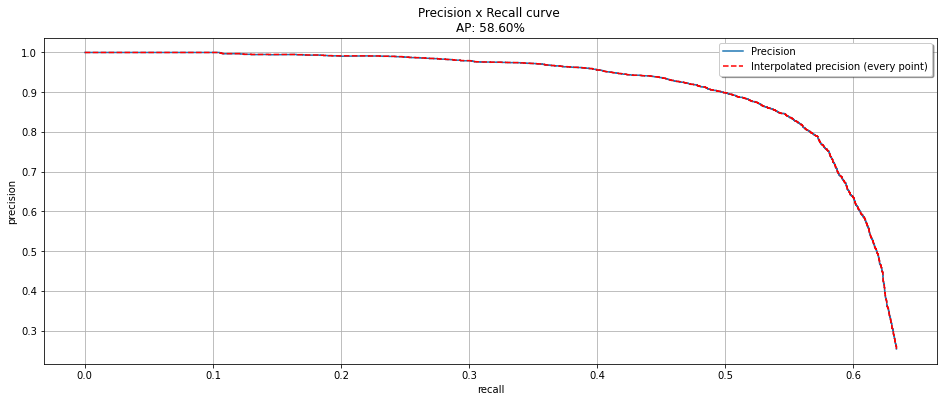

In [69]:
PlotPrecisionRecallCurve(r_original)

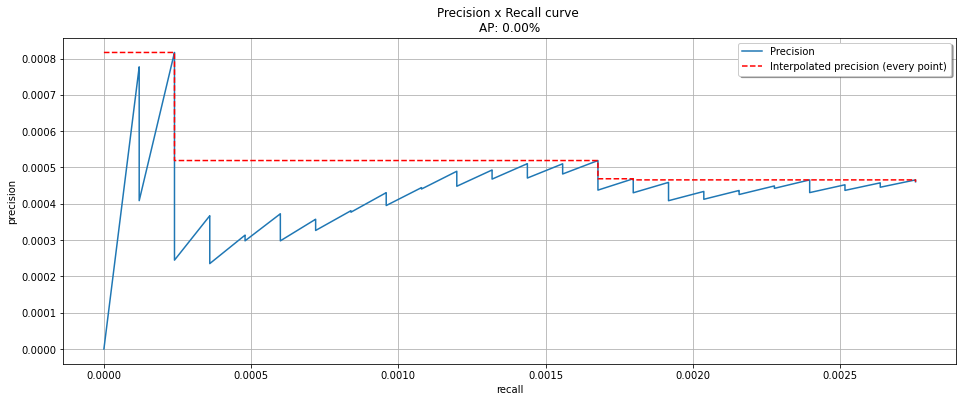

In [70]:
PlotPrecisionRecallCurve(r_adversarial_samples)